In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from s3fs import S3FileSystem, S3Map

import cmocean as cm

produced with ../../MarineHeatWaves/NOTEBOOKS/stack_imos_mooring...
../../../IMOS/AODN//IMOS_Stack_Mooring_NWSBRW_202305_TEMP_60s.nc
../../../IMOS/AODN//IMOS_Stack_Mooring_NWSBRW_202312_TEMP_60s.nc

In [57]:
datafile = 'imos-data/IMOS/ANMN/QLD/NWSBRW/gridded_timeseries/IMOS_ANMN-QLD_TZ_20190731_NWSBRW_FV02_TEMP-gridded-timeseries_END-20240528_C-20240914.nc'
sitename='NWSBRW'
z_bot = -200

outfile = '../DATA/mooring_steric_ssh_{}_v4.nc'.format(sitename)


In [28]:
# Access the AODN s3 bucket like this
fs = S3FileSystem(anon=True)
aodn = fs.ls('imos-data')

In [29]:
def open_file_nocache(fname):
    fileobj = fs.open(fname)
    return xr.open_dataset(fileobj)
    

ds = open_file_nocache(datafile)
ds

<xarray.Dataset>
Dimensions:     (TIME: 42288, DEPTH: 21)
Coordinates:
  * DEPTH       (DEPTH) float32 0.0 10.0 20.0 30.0 ... 170.0 180.0 190.0 200.0
  * TIME        (TIME) datetime64[ns] 2019-07-31T08:00:00 ... 2024-05-28T06:0...
    LONGITUDE   float64 ...
    LATITUDE    float64 ...
Data variables:
    TEMP        (TIME, DEPTH) float32 ...
    TEMP_count  (TIME) int16 ...
Attributes: (12/42)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Gridded Time Series Product: This file con...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Australian Ocean Data Network (AODN)
    author_email:                  info@aodn.org.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    source_file_download:          https://s3-ap-southeast-2.amazonaws.com/im...
    source_file_opendap:           http://thredds.aodn.org.au/thredds/dodsC/I...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2024-05-28T06:00:00Z
    time_coverage_start:           2019-07-31T08:00:00Z
    title:                         Gridded Time Series Product: TEMP interpol...

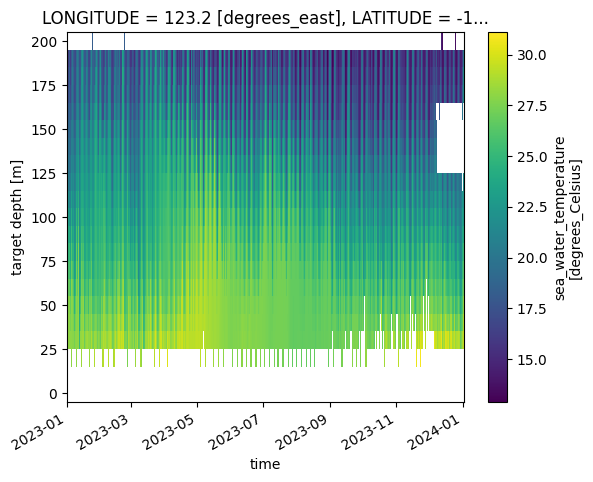

In [43]:
TEMP = ds['TEMP'].sel(TIME=slice('2023-01-01','2024-01-01'))
TEMP.T.plot()

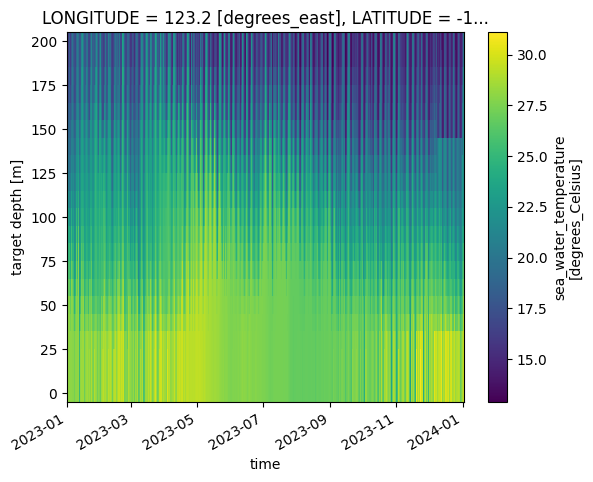

In [49]:
#T_fill = ds['TEMP'].interpolate_na('DEPTH', method='linear',fill_value='extrapolate')
T_fill = TEMP.interpolate_na('DEPTH', method='nearest',fill_value='extrapolate').T

T_fill.plot()

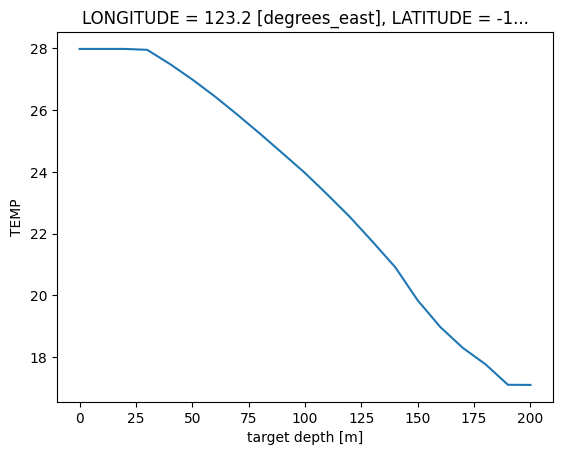

In [50]:
T_bar = T_fill.mean(axis=1)
T_bar.plot()

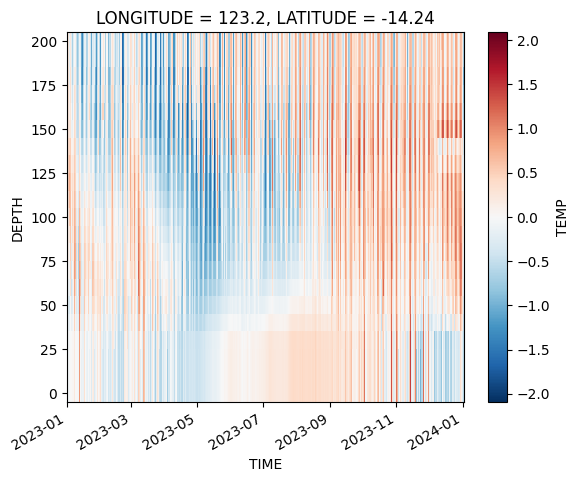

In [51]:
# Nonlinear EOS
import gsw
rho0 = 1024

rho = gsw.pot_rho_t_exact( 34.6, T_fill,-ds['DEPTH'], 0)

rho = xr.where(np.isnan(rho), rho0, rho)

rho_bar = rho.mean(axis=1)

rho_pr2 = rho - rho_bar

rho_pr2.plot()

In [52]:
# Calculate the vertical grid spacing
z_top = 0

z_mid = 0.5*(ds['DEPTH'][0:-1].values + ds['DEPTH'][1:].values)
z_mid.shape, ds['DEPTH'].shape

# z = np.hstack([[z_bot], z_mid, [z_top]])
z = np.hstack([[z_top], z_mid, [-z_bot]])

dz = z[1:] - z[0:-1]
dz

array([ 5., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10.,  5.])

(array([19358., 19417., 19478., 19539., 19601., 19662., 19723.]),
 [Text(19358.0, 0, '2023-01'),
  Text(19417.0, 0, '2023-03'),
  Text(19478.0, 0, '2023-05'),
  Text(19539.0, 0, '2023-07'),
  Text(19601.0, 0, '2023-09'),
  Text(19662.0, 0, '2023-11'),
  Text(19723.0, 0, '2024-01')])

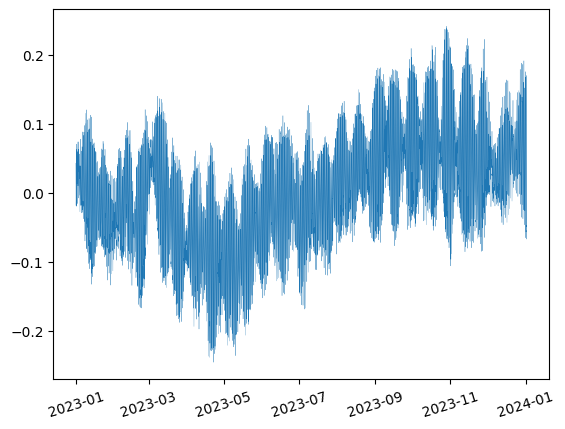

In [54]:
ssh=np.sum(rho_pr2/rho0*dz[:,None], axis=0)
# ssh=-np.sum(rho_pr2/rho0*dz[:,None], axis=0) # !! Note the negative !!

plt.plot(TEMP.TIME, ssh,      lw =0.2)
plt.xticks(rotation=17)

In [58]:
rho_pr2['name'] = 'rho_pr'
rho_pr2.attrs = {'long_name':'density fluctuation', 'units':'kg m-3',
                'equation_of_state':'non-linear','rho0':rho0}
               #'equation_of_state':'linear','alpha':alpha,'rho0':rho0}

da_ssh = xr.DataArray(ssh, coords={'time':TEMP.TIME},
                     attrs={'long_name':'steric height', 'units':'m'})


ds_Tbar = xr.DataArray(rho_bar, coords={'z_nom':TEMP.DEPTH},
                       attrs={'long_name':'background density', 'units':'kg m-3'})

ds_out = xr.Dataset({'eta_steric':da_ssh, 'rho_pr':rho_pr2, 'rho_background':ds_Tbar})

ds_out.attrs = {'original file':datafile}

ds_out.to_netcdf(outfile)
print(outfile)
ds_out


../DATA/mooring_steric_ssh_NWSBRW_v4.nc


<xarray.Dataset>
Dimensions:         (TIME: 8784, DEPTH: 21)
Coordinates:
    time            (TIME) datetime64[ns] 2023-01-01 ... 2024-01-01T23:00:00
  * TIME            (TIME) datetime64[ns] 2023-01-01 ... 2024-01-01T23:00:00
  * DEPTH           (DEPTH) float32 0.0 10.0 20.0 30.0 ... 180.0 190.0 200.0
    LONGITUDE       float64 123.2
    LATITUDE        float64 -14.24
    name            <U6 'rho_pr'
    z_nom           (DEPTH) float32 0.0 10.0 20.0 30.0 ... 180.0 190.0 200.0
Data variables:
    eta_steric      (TIME) float64 0.04356 0.02112 -0.01654 ... -0.06648 -0.0539
    rho_pr          (DEPTH, TIME) float64 -0.1742 -0.1747 ... -0.7182 -0.8341
    rho_background  (DEPTH) float64 1.022e+03 1.022e+03 ... 1.025e+03 1.025e+03
Attributes:
    original file:  imos-data/IMOS/ANMN/QLD/NWSBRW/gridded_timeseries/IMOS_AN...